<h1><u>SaaS Subscription Revenue Leakage Detection & Recovery Analytics</u></h1>

<h2>Business Problem Overview</h2>

A mid-sized SaaS subscription company offers tier-based plans (Basic, Pro, Premium) with monthly and annual billing. The company relies heavily on recurring revenue through auto-renewals and digital payment methods.
Despite steady growth in user acquisition and product usage, the finance team has observed a gap between expected subscription revenue and actual collections. Monthly revenue reports show inconsistencies that cannot be fully explained by customer churn alone.
Preliminary investigations indicate that the company is experiencing subscription revenue leakage, where users continue to access paid features without corresponding successful billing.

<h3>Objective of the Analytics Initiative</h3>

The company aims to build a subscription revenue leakage analytics framework to:
- Identify mismatches between subscription status, usage, and payments
- Quantify revenue leakage by plan, geography, payment method, and customer segment
- Distinguish true churn from hidden revenue leakage
- Flag high-risk accounts for proactive recovery actions
- Provide actionable insights to improve revenue realization and retention


<h2>Import The Packages</h2>

In [7]:
### **# Import packages for data manipulation**
import numpy as np
import pandas as pd

### Import packages for Sql query##
from sqlalchemy import create_engine
engine= create_engine("sqlite:///revenue.db",echo=True)
import sqlite3

### **# Import packages for data visualization**
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [8]:
# Define a function for data ingetion 
def data_ingestion(data_frame,table,engine):
    revenue.to_sql(table,con=engine, if_exists='replace',index=False)

In [9]:
# Upload the data in Database
path="C:/Users/DELL/Downloads/revenue_leakage"

for file in os.listdir(path):
    revenue=pd.read_csv(path+"/"+ file)
    print(revenue.shape)
    data_ingestion(revenue,file[:-4],engine)

(16000, 8)
2026-02-08 11:50:29,408 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 11:50:29,450 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("payments")
2026-02-08 11:50:29,450 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 11:50:29,467 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("payments")
2026-02-08 11:50:29,474 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 11:50:29,487 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2026-02-08 11:50:29,494 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 11:50:29,506 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2026-02-08 11:50:29,510 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 11:50:29,527 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("payments")
2026-02-08 11:50:29,532 INFO sqlalchemy.engine.Engine [raw sql] (

<h2>Data Extraction, Cleaning & Transformation </h2>

<h3>Business Challenges</h3>

* Active subscriptions without successful payment
* Users consuming services after failed payment
* Downgraded plans still billed at higher price
* Free trial users converting usage but not billing
* Failure rate by payment method
* Revenue stuck in “Pending” state
* Downgraded + old billing


In [12]:
#  create a connection for sql queries 
conn= sqlite3.connect("revenue.db")
tables= pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",conn)
tables

,name
0,payments
1,subscriptions
2,support_events
3,usage_metrics
4,users


In [13]:
for table in tables ["name"]:
    display(pd.read_sql(f'select * from {table} LIMIT 5',conn))

,payment_id,subscription_id,user_id,payment_date,amount,payment_status,payment_method,failure_reason
0,50001,15229,4959,2023-10-14,3999,Success,UPI,Timeout
1,50002,13767,4617,2023-08-20,3999,Success,UPI,Timeout
2,50003,14617,1545,2023-05-28,3999,Success,Card,Insufficient Funds
3,50004,13716,4218,2024-01-01,1999,Success,Card,None
4,50005,14522,4482,2023-06-08,3999,Success,Wallet,Gateway Error


,subscription_id,user_id,plan_name,billing_cycle,plan_price,start_date,renewal_date,subscription_status
0,10001,2337,Pro,Monthly,1999,2023-02-02,2023-03-04,Active
1,10002,1581,Pro,Monthly,1999,2023-08-31,2024-08-30,Cancelled
2,10003,1409,Pro,Monthly,1999,2022-04-03,2022-05-03,Active
3,10004,175,Premium,Annual,3999,2022-04-12,2022-05-12,Active
4,10005,474,Pro,Annual,1999,2022-04-08,2023-04-08,Active


,user_id,event_type,event_date,resolution_status
0,2637,Downgrade,2024-06-11,Closed
1,1929,Refund,2024-03-19,Closed
2,584,Refund,2023-03-04,Closed
3,4701,Refund,2023-11-02,Closed
4,753,Downgrade,2023-01-05,Closed


,user_id,login_count,feature_usage_score,last_active_date,premium_feature_used
0,1,58,37,2024-09-15,No
1,2,70,83,2024-09-11,No
2,3,93,70,2024-10-16,Yes
3,4,68,87,2024-11-03,Yes
4,5,98,32,2024-10-01,Yes


,user_id,signup_date,country,acquisition_channel,company_size,user_status
0,1,2022-04-13,Australia,Partner,Mid,Active
1,2,2023-03-12,Australia,Referral,Mid,Active
2,3,2024-05-10,Germany,Paid,Enterprise,Active
3,4,2022-09-28,USA,Referral,SMB,Active
4,5,2022-04-17,Germany,Organic,SMB,Active


<h3>Summarizing the users table by user status, comapny size and country .</h3>

In [15]:
# Most inactive user filter by company
display(pd.read_sql('with failure_counts as(select u.country,p.failure_reason,payment_method ,count(user_status) as No_Active_user ,sum(p.amount) Total_amount, row_number() over (partition by u.country order by count(user_status) desc) as FC from payments p join users u on p.user_id = u.user_id join subscriptions s on p.subscription_id = s.subscription_id  where subscription_status="Active"and payment_status="Failed" and user_status="Active" and failure_reason !="None" group by country,failure_reason )select country,failure_reason,payment_method ,No_Active_user ,Total_amount from failure_counts where FC =1  group by country order by No_Active_user desc ',conn))


,country,failure_reason,payment_method,No_Active_user,Total_amount
0,USA,Gateway Error,Card,83,225917
1,UK,Insufficient Funds,UPI,79,189921
2,Australia,Gateway Error,Card,75,183925
3,India,Gateway Error,Wallet,72,160928
4,Germany,Gateway Error,Card,69,164931


In [16]:
# select the country and comapnies size with least active and most inactive user
display(pd.read_sql("select company_size, country,count(user_status) as ActiveUser_by_country from users where user_status='Active' group by country,company_size  order by ActiveUser_by_country asc",conn))
display(pd.read_sql("select company_size, country,count(user_status) as InactiveUser_by_country from users where user_status='Inactive' group by country ,company_size order by InactiveUser_by_country desc",conn))

,company_size,country,ActiveUser_by_country
0,SMB,Germany,252
1,Enterprise,India,253
2,Enterprise,UK,263
3,SMB,UK,263
4,Mid,Australia,269
5,Mid,Germany,272
6,Enterprise,Germany,282
7,SMB,Australia,286
8,Enterprise,Australia,290
9,Mid,India,299


,company_size,country,InactiveUser_by_country
0,Enterprise,USA,63
1,Mid,Australia,62
2,SMB,UK,62
3,SMB,Germany,58
4,Enterprise,Germany,53
5,Mid,Germany,53
6,Enterprise,Australia,52
7,Mid,USA,48
8,Mid,India,47
9,Enterprise,India,46


In [17]:
#No of Inactive user by company size
display(pd.read_sql("select user_status,company_size, count(*) as no_of_active_user from users where user_status='Inactive' group by user_status,company_size order by no_of_active_user desc",conn))

#No of login count of Inactive user by company size
display(pd.read_sql("select u.company_size, sum(m.login_count) as no_of_seats from users  as u join usage_metrics as m on u.user_id = m.user_id where user_status='Inactive'  group by company_size ",conn))

,user_status,company_size,no_of_active_user
0,Inactive,Enterprise,255
1,Inactive,Mid,254
2,Inactive,SMB,243


,company_size,no_of_seats
0,Enterprise,15653
1,Mid,16170
2,SMB,14502


<b>NOTE:</b> As per the above queries , it is clear that Enterprise size companies has the high no of Inactive user of 255 user followed by Mid and SMB size company has the lowest no of Inactive user .The Enterprise size companies has discontinue the using of SaaS software and  total loss of 15653 login counts. The Enterprise of USA has the highest no 63 user which are inactive , which will lead to loss of revenue. It will be recover by convert the inactive user to active user.SMB Germany has highest no of  active user.


<h3>Detect Revenue Leakage points across the Subscription Lifecycle</h3>

In [61]:
# find the no transaction and amount by different payment status
display(pd.read_sql('select payment_status ,count(payment_status) "No of Transaction", sum(amount) "Total Amount of Revenue Generated " from payments group by payment_status order by "Total amount of Revenue Generated " desc',conn))

# no of user who are not make successful payments but using the software
display(pd.read_sql('select p.payment_status, payment_method,count(u.user_id) "No of Active User ",s.subscription_status, sum(p.amount) Total_amount from payments p join users u on p.user_id = u.user_id join subscriptions s on p.subscription_id = s.subscription_id  where user_status ="Active"  and subscription_status ="Active" group by p.payment_status,payment_method ',conn))


,payment_status,No of Transaction,Total Amount of Revenue Generated
0,Success,12515,29271485
1,Failed,2397,5664603
2,Pending,1088,2478912


,payment_status,payment_method,No of Active User,subscription_status,Total_amount
0,Failed,Card,499,Active,1217501
1,Failed,UPI,426,Active,1023574
2,Failed,Wallet,461,Active,1048539
3,Pending,Card,224,Active,526776
4,Pending,UPI,196,Active,444804
5,Pending,Wallet,209,Active,477791
6,Success,Card,2504,Active,5796496
7,Success,UPI,2510,Active,5944490
8,Success,Wallet,2517,Active,5916483


In [63]:
# reasons for unsuccessful transaction with count and total amount
display(pd.read_sql('select payment_method, failure_reason ,  count(failure_reason) "Total count of payment failure",sum(amount) as Total_amount from payments  where payment_status = "Failed" and failure_reason!= "None" group by payment_method order by "Total count of payment failure" desc',conn))

,payment_method,failure_reason,Total count of payment failure,Total_amount
0,Card,Timeout,574,1399426
1,Wallet,Gateway Error,562,1307438
2,UPI,Insufficient Funds,555,1310445


In [25]:
display(pd.read_sql('select payment_method , count(payment_status) "Total Successful Transaction",sum(amount) as Total_amount from payments  where payment_status = "Success" group by payment_method order by Total_amount desc',conn))

,payment_method,Total Successful Transaction,Total_amount
0,UPI,4190,9879810
1,Wallet,4170,9763830
2,Card,4155,9627845


In [26]:
# unearned revenue by unactive subscription_status
display(pd.read_sql('select s.subscription_status,count(s.subscription_status) , sum(p.amount) Total_amount from payments p join subscriptions s on p.subscription_id = s.subscription_id where subscription_status !="Active" group by subscription_status ',conn))

# reasons for non active subscription_status 
display(pd.read_sql('select se.event_type, se.resolution_status,s.subscription_status ,count(se.user_id) "Total count" from payments p join subscriptions s on p.subscription_id = s.subscription_id join support_events se on se.user_id=s.user_id where subscription_status !="Expired" group by event_type,subscription_status,resolution_status  order by "Total count" desc ,subscription_status',conn))

,subscription_status,count(s.subscription_status),Total_amount
0,Cancelled,2358,5449642
1,Expired,2462,5781538


,event_type,resolution_status,subscription_status,Total count
0,Refund,Closed,Active,984
1,Complaint,Closed,Active,969
2,Downgrade,Closed,Active,940
3,Refund,Open,Active,263
4,Complaint,Closed,Cancelled,228
5,Downgrade,Open,Active,225
6,Complaint,Open,Active,222
7,Refund,Closed,Cancelled,212
8,Downgrade,Closed,Cancelled,126
9,Downgrade,Open,Cancelled,65


<b>NOTE:</b> There are total 1386 user who are failed in payment but actively using services with total value of 3289614 and 629 Active user with total amount of 1449371 which are pending . There are total 1386 user whose subscription is still active ,this are loss for revenue who are using the subscription services but failed the payment.


<h3>Retrive data for EDA into single dataframe</h3>

In [29]:
raw_data=pd.read_sql_query('select p.subscription_id ,p.user_id , p.amount,p.payment_status,p.payment_method,p.failure_reason ,s.plan_name,s.billing_cycle ,s.plan_price,s.start_date ,s.renewal_date,s.subscription_status,u.country,u.acquisition_channel,u.company_size,u.user_status,se.event_type,se.event_date,se.resolution_status,um.login_count,um.feature_usage_score,um.last_active_date ,um.premium_feature_used  from payments p join subscriptions s on p.subscription_id=s.subscription_id join users u on s.user_id=u.user_id left join support_events se on p.user_id=se.user_id join usage_metrics um on p.user_id=um.user_id ',conn) 

In [30]:
pd.set_option('display.max_columns', None)
raw_data.head(10)

,subscription_id,user_id,amount,payment_status,payment_method,failure_reason,plan_name,billing_cycle,plan_price,start_date,renewal_date,subscription_status,country,acquisition_channel,company_size,user_status,event_type,event_date,resolution_status,login_count,feature_usage_score,last_active_date,premium_feature_used
0,15229,4959,3999,Success,UPI,Timeout,Basic,Monthly,999,2023-01-23,2023-02-22,Active,India,Partner,SMB,Active,None,None,None,110,71,2024-11-27,No
1,13767,4617,3999,Success,UPI,Timeout,Pro,Monthly,1999,2023-03-03,2024-03-02,Active,India,Organic,Enterprise,Active,Complaint,2023-09-24,Closed,91,89,2024-09-12,Yes
2,13767,4617,3999,Success,UPI,Timeout,Pro,Monthly,1999,2023-03-03,2024-03-02,Active,India,Organic,Enterprise,Active,Refund,2023-09-17,Open,91,89,2024-09-12,Yes
3,14617,1545,3999,Success,Card,Insufficient Funds,Basic,Monthly,999,2022-03-25,2023-03-25,Active,UK,Partner,Mid,Inactive,None,None,None,110,42,2024-10-02,No
4,13716,4218,1999,Success,Card,None,Basic,Monthly,999,2024-02-04,2024-03-05,Expired,Australia,Referral,Mid,Active,Complaint,2024-10-08,Closed,35,10,2024-11-30,Yes
5,14522,4482,3999,Success,Wallet,Gateway Error,Pro,Monthly,1999,2023-09-10,2023-10-10,Active,Australia,Referral,Enterprise,Active,None,None,None,42,19,2024-11-11,Yes
6,12122,3414,1999,Success,Card,Insufficient Funds,Premium,Monthly,3999,2022-09-12,2022-10-12,Active,USA,Paid,Mid,Active,None,None,None,73,79,2024-10-15,Yes
7,10343,4880,3999,Success,Card,None,Premium,Annual,3999,2024-01-27,2025-01-26,Active,USA,Paid,SMB,Active,Complaint,2024-03-27,Open,40,26,2024-10-09,No
8,14467,3782,3999,Pending,Card,Timeout,Pro,Monthly,1999,2023-09-27,2023-10-27,Active,UK,Referral,Enterprise,Active,None,None,None,26,89,2024-09-14,No
9,12932,919,999,Success,Card,None,Basic,Annual,999,2022-07-21,2023-07-21,Active,Germany,Paid,Enterprise,Active,None,None,None,85,30,2024-10-09,Yes


In [31]:
raw_data.columns

Index(['subscription_id', 'user_id', 'amount', 'payment_status',
       'payment_method', 'failure_reason', 'plan_name', 'billing_cycle',
       'plan_price', 'start_date', 'renewal_date', 'subscription_status',
       'country', 'acquisition_channel', 'company_size', 'user_status',
       'event_type', 'event_date', 'resolution_status', 'login_count',
       'feature_usage_score', 'last_active_date', 'premium_feature_used'],
      dtype='object')

In [32]:
final_data= raw_data.drop(['subscription_id','acquisition_channel','event_date',],axis=1)

In [33]:
final_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,16602.0,NaN,NaN,NaN,2495.30147,1448.040247,1.0,1231.25,2491.0,3751.0,5000.0
amount,16602.0,NaN,NaN,NaN,2334.923383,1249.433467,999.0,999.0,1999.0,3999.0,3999.0
payment_status,16602,3,Success,12990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,16602,3,Card,5570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failure_reason,11693,3,Insufficient Funds,4218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
plan_name,16602,3,Pro,6866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
billing_cycle,16602,2,Monthly,12561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
plan_price,16602.0,NaN,NaN,NaN,1993.880135,1080.645641,999.0,999.0,1999.0,1999.0,3999.0
start_date,16602,796,2024-02-11,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
renewal_date,16602,1107,2023-07-18,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
final_data.head(10)

,user_id,amount,payment_status,payment_method,failure_reason,plan_name,billing_cycle,plan_price,start_date,renewal_date,subscription_status,country,company_size,user_status,event_type,resolution_status,login_count,feature_usage_score,last_active_date,premium_feature_used
0,4959,3999,Success,UPI,Timeout,Basic,Monthly,999,2023-01-23,2023-02-22,Active,India,SMB,Active,None,None,110,71,2024-11-27,No
1,4617,3999,Success,UPI,Timeout,Pro,Monthly,1999,2023-03-03,2024-03-02,Active,India,Enterprise,Active,Complaint,Closed,91,89,2024-09-12,Yes
2,4617,3999,Success,UPI,Timeout,Pro,Monthly,1999,2023-03-03,2024-03-02,Active,India,Enterprise,Active,Refund,Open,91,89,2024-09-12,Yes
3,1545,3999,Success,Card,Insufficient Funds,Basic,Monthly,999,2022-03-25,2023-03-25,Active,UK,Mid,Inactive,None,None,110,42,2024-10-02,No
4,4218,1999,Success,Card,None,Basic,Monthly,999,2024-02-04,2024-03-05,Expired,Australia,Mid,Active,Complaint,Closed,35,10,2024-11-30,Yes
5,4482,3999,Success,Wallet,Gateway Error,Pro,Monthly,1999,2023-09-10,2023-10-10,Active,Australia,Enterprise,Active,None,None,42,19,2024-11-11,Yes
6,3414,1999,Success,Card,Insufficient Funds,Premium,Monthly,3999,2022-09-12,2022-10-12,Active,USA,Mid,Active,None,None,73,79,2024-10-15,Yes
7,4880,3999,Success,Card,None,Premium,Annual,3999,2024-01-27,2025-01-26,Active,USA,SMB,Active,Complaint,Open,40,26,2024-10-09,No
8,3782,3999,Pending,Card,Timeout,Pro,Monthly,1999,2023-09-27,2023-10-27,Active,UK,Enterprise,Active,None,None,26,89,2024-09-14,No
9,919,999,Success,Card,None,Basic,Annual,999,2022-07-21,2023-07-21,Active,Germany,Enterprise,Active,None,None,85,30,2024-10-09,Yes


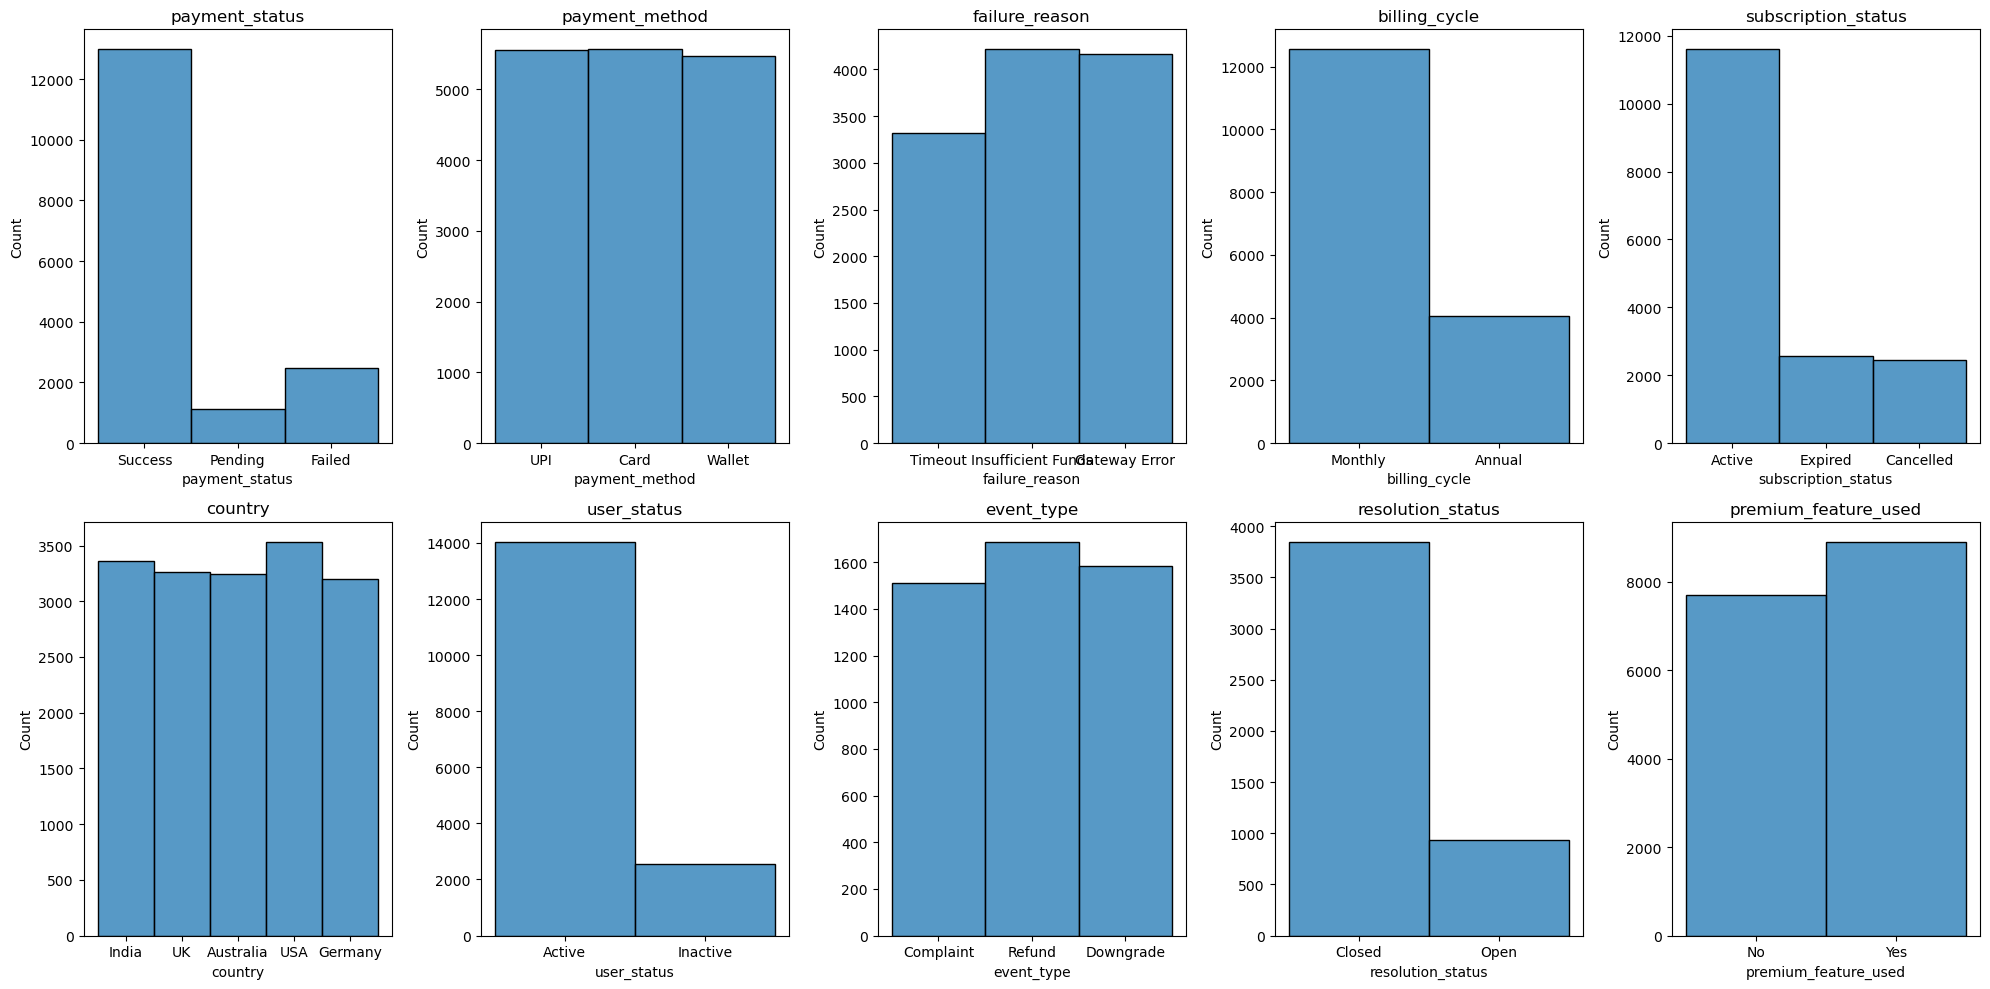

In [35]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,5,1)
sns.histplot(final_data['payment_status']).set_title('payment_status')
plt.subplot(2,5,2)
sns.histplot(final_data['payment_method']).set_title('payment_method')
plt.subplot(2,5,3)
sns.histplot(final_data['failure_reason']).set_title('failure_reason')
plt.subplot(2,5,4)
sns.histplot(final_data['billing_cycle']).set_title('billing_cycle')
plt.subplot(2,5,5)
sns.histplot(final_data['subscription_status']).set_title('subscription_status')
plt.subplot(2,5,6)
sns.histplot(final_data['country']).set_title('country')
plt.subplot(2,5,7)
sns.histplot(final_data['user_status']).set_title('user_status')
plt.subplot(2,5,8)
sns.histplot(final_data['event_type']).set_title('event_type')
plt.subplot(2,5,9)
sns.histplot(final_data['resolution_status']).set_title('resolution_status')
plt.subplot(2,5,10)
sns.histplot(final_data['premium_feature_used']).set_title('premium_feature_used')



plt.tight_layout()
plt.show()

<h2>Key Performance Indicator</h2>

In [37]:
print('Total Recurring Revenue')
#Total expected subscription revenue for active plans
TRR=(final_data[final_data["subscription_status"]=="Active"]["amount"].sum())
print(TRR)

Total Recurring Revenue
27159391


In [38]:
print('Realized Revenue')
#Total actual subscription revenue for active plans
AR =(final_data[(final_data["subscription_status"]=="Active") & (final_data['payment_status']=="Success")]["amount"].sum())
print(AR)

Realized Revenue
21322883


In [39]:
print("Revenue Leakage Amount")
RLA= TRR-AR
print(RLA)

Revenue Leakage Amount
5836508


In [40]:
print("Revenue Leakage %")
RL= round((RLA/TRR*100),2)
print(RL)

Revenue Leakage %
21.49


<h1>Business Insights</h1>

<h2>Key Business Insights</h2>

1. <b>21% of Expected Revenue Is Not Being Collected</b>

     ₹5.836M in revenue is leaking despite active subscriptions, directly impacting topline growth.

2. <b>Customers Are Using the Product Without Paying</b>

    1,386 active users continue to consume services after payment failure or delay.

3. <b>Hidden Revenue Loss Is Larger Than Reported Churn</b>

    Revenue leakage from active users exceeds losses from cancelled or expired subscriptions.

4. <b>Payment Failures Are a Structural Revenue Risk</b>

    Gateway errors, insufficient funds, and timeouts are systemic—not isolated—issues.

5. <b>Card Payments Are the Biggest Bottleneck</b>

    Cards show the lowest success rates, driven primarily by timeout failures.

6. <b>Gateway Errors Have the Highest Financial Impact</b>

    ₹9.21M is lost due to gateway-related failures alone among active users.

7. <b>₹1.45M Is Stuck in Pending Payments</b>

    This is near-term, recoverable revenue requiring immediate executive attention.

8. <b>UPI and Wallets Are High-Performing Channels</b>

    These methods deliver ~80% success rates and should be strategically encouraged.

9. <b>Enterprise Customers Are Disengaging at a Higher Rate</b>

    The Enterprise segment has the highest inactive users and declining product usage.

10. <b>Geographic Concentration of Leakage Increases Risk</b>

    The USA is the largest contributor to leakage, primarily through card gateway failures.

11. <b>High-Value Plans Are Most Exposed</b>

    The Pro plan alone accounts for 40% of total revenue leakage.

12. <b>Renewal Revenue Is at Serious Risk</b>

    ₹4.09 in monthly recurring revenue is exposed due to failed renewal payments.

13. <b>A Small Group of Users Drives Disproportionate Loss</b>

    Repeat payment failures by a limited set of accounts create outsized revenue risk.

14. <b>Billing and Subscription Systems Are Misaligned</b>

    Plan downgrades, trials, and usage controls are not fully synchronized with billing.

15. <b>Current Controls Allow Revenue Leakage to Persist</b>

    Lack of enforcement between payment status and service access enables ongoing loss.

<h2>Recommended Strategic Actions with Metrics</h2>

1. <b>Mandate Pay-to-Use Enforcement</b>

Action: Restrict service access after repeated payment failures.

-- Metric Targets:

Reduce active unpaid users from 1,386 → <300

Recover ₹20–25M within 90 days

Cut revenue leakage from 21% → <10%

2. <b>Stabilize Card Payment Infrastructure</b>

Action: Fix gateway timeouts and improve card success rates.

-- Metric Targets:

Increase card payment success rate by +15–20%

Reduce timeout failures from 574 → <200 transactions/month

Recover ₹10M+ annually from card-related failures

3. <b>Launch an Executive-Led Revenue Recovery Drive</b>

Action: Dedicated task force for failed & pending payments.

-- Metric Targets:

Recover ₹1.45M pending within 60 days

Close 65–70% of pending transactions from cards which is ₹0.52M highest among all 

Reduce pending transaction volume by 50%

4. <b>Create a Revenue Leakage Command Center</b>

Action: Weekly executive dashboard and ownership.

-- Metric Targets:

Track leakage weekly by plan, geo, payment method

Reduce total leakage by ₹0.5M per month

Maintain leakage trend <2% MoM increase

5. <b>Prioritize High-Value Plans and Accounts</b>

Action: Focus on Pro plan and high-MRR users.

-- Metric Targets:

Reduce Pro plan leakage from 40% → <20%

Recover ₹1.2–1.5M from Pro users

Achieve 80% recovery rate for top 10% MRR accounts

6. <b>Reduce Renewal Failure Risk</b>

Action: Pre-renewal validation and smart retries.

-- Metric Targets:

Protect ₹4.09M MRR at risk

Reduce renewal failures by 30–40%

Improve renewal payment success rate to >90%

7. <b>Optimize Payment Strategy by Geography</b>

Action: Regional gateway and method optimization.

-- Metric Targets:

Reduce USA leakage by 50% (₹2.25M → ~₹1.1M)

Improve geo-specific success rates by +10–15%

Decrease gateway errors by 40% in top 5 countries

8. <b>Fix Billing Logic Gaps<b>

Action: Align billing with plan changes and trial conversions.

-- Metric Targets:

Eliminate 100% of overbilling from downgraded plans

Convert 25–30% of trial users into paid accounts

Prevent ₹5M+ annual revenue loss from billing mismatches

9. <b>Re-Engage Enterprise Customers</b>

Action: Target inactive Enterprise users.

-- Metric Targets:

Reactivate 30% of 255 inactive Enterprise users

Recover ₹0.8–10M in Enterprise MRR

Reduce Enterprise inactivity rate by 25%

10. <b>Assign Clear Ownership and Performance KPIs</b>

Action: Tie outcomes to leadership accountability.

-- Metric Targets:

Set OKRs for Revenue Realization, Payment Success, Leakage %

Achieve >95% payment success rate across all methods

Reduce total revenue leakage from ₹5.836M → <₹3M in 6 months




<h3>CEO Summary Metric Snapshot</h3>

* <b>Revenue at Risk Identified: ₹5.836M

* <b>Recoverable in 90 Days: ₹3.5–4.0M

* <b>MRR Protected: ₹4.09M

* <b>Primary Fix Areas: Card payments, gateway errors, enforcement controls

<h2>Conclusion </h2>
By implementing this analytics solution, the SaaS company expects to:

* Improve billing accuracy and revenue realization
* Reduce revenue leakage through early detection
* Enhance customer lifecycle management
* Enable data-driven decisions for pricing, payment retries, and customer communication
